<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Trading Strategies (b)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [2]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

## Linear OLS Regression

### The Data

In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [4]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [5]:
symbol = 'EUR='

In [6]:
data = pd.DataFrame(raw[symbol])

In [7]:
data['returns'] = np.log(data / data.shift(1))

In [8]:
data.dropna(inplace=True)

In [9]:
data['direction'] = np.sign(data['returns']).astype(int)

In [10]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


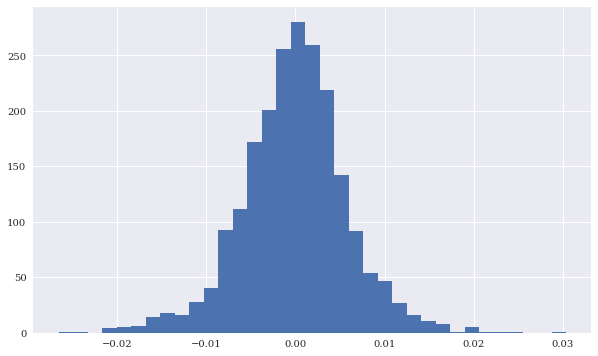

In [134]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_01.png')

In [12]:
lags = 2

In [13]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [14]:
create_lags(data)

In [15]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [16]:
data.dropna(inplace=True)

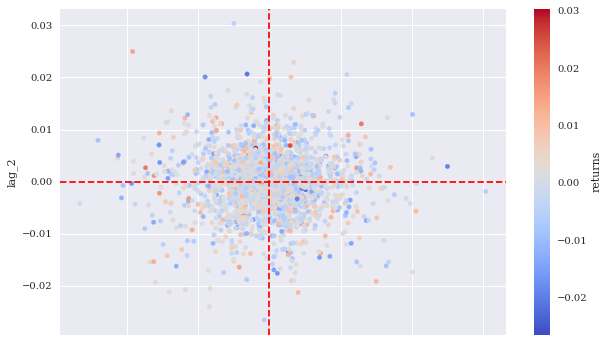

In [17]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('../../images/ch15/strat_ml_02.png');

### Regression

In [18]:
from sklearn.linear_model import LinearRegression  

In [19]:
model = LinearRegression()  

In [20]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  

In [21]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [22]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


In [23]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [24]:
data['pos_ols_1'].value_counts()  

-1    1847
 1     288
Name: pos_ols_1, dtype: int64

In [25]:
data['pos_ols_2'].value_counts()  

 1    1377
-1     758
Name: pos_ols_2, dtype: int64

In [26]:
data['pos_ols_1']

Date
2010-01-07   -1
2010-01-08    1
2010-01-11   -1
2010-01-12   -1
2010-01-13   -1
             ..
2018-06-25   -1
2018-06-26   -1
2018-06-27    1
2018-06-28   -1
2018-06-29   -1
Name: pos_ols_1, Length: 2135, dtype: int64

In [27]:
data['pos_ols_1'].diff()

Date
2010-01-07    NaN
2010-01-08    2.0
2010-01-11   -2.0
2010-01-12    0.0
2010-01-13    0.0
             ... 
2018-06-25    0.0
2018-06-26    0.0
2018-06-27    2.0
2018-06-28   -2.0
2018-06-29    0.0
Name: pos_ols_1, Length: 2135, dtype: float64

In [28]:
(data['pos_ols_1'].diff() != 0).sum()  

555

In [29]:
(data['pos_ols_2'].diff() != 0).sum()  

762

In [30]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [31]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [32]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.810644
strat_ols_1    0.942422
strat_ols_2    1.339286
dtype: float64

In [33]:
(data['direction'] == data['pos_ols_1']).value_counts()  

False    1093
True     1042
dtype: int64

In [34]:
(data['direction'] == data['pos_ols_2']).value_counts()  

True     1096
False    1039
dtype: int64

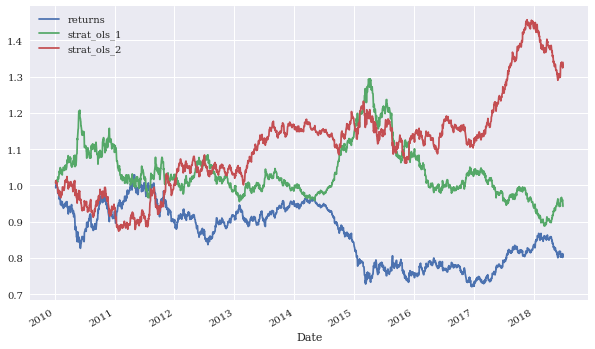

In [35]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_03.png');

## Clustering

In [36]:
from sklearn.cluster import KMeans

In [37]:
model = KMeans(n_clusters=2, random_state=0)  #  <1>

In [38]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [39]:
data['pos_clus'] = model.predict(data[cols])

In [40]:
data['pos_clus']

Date
2010-01-07    1
2010-01-08    0
2010-01-11    1
2010-01-12    0
2010-01-13    0
             ..
2018-06-25    1
2018-06-26    0
2018-06-27    0
2018-06-28    0
2018-06-29    1
Name: pos_clus, Length: 2135, dtype: int32

In [41]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [42]:
data['pos_clus'].values

array([-1,  1, -1, ...,  1,  1, -1])

In [43]:
data[cols].iloc[:, 1]

Date
2010-01-07   -0.002988
2010-01-08    0.003058
2010-01-11   -0.006544
2010-01-12    0.006544
2010-01-13    0.006984
                ...   
2018-06-25    0.002676
2018-06-26    0.004644
2018-06-27    0.004024
2018-06-28   -0.004883
2018-06-29   -0.008018
Name: lag_2, Length: 2135, dtype: float64

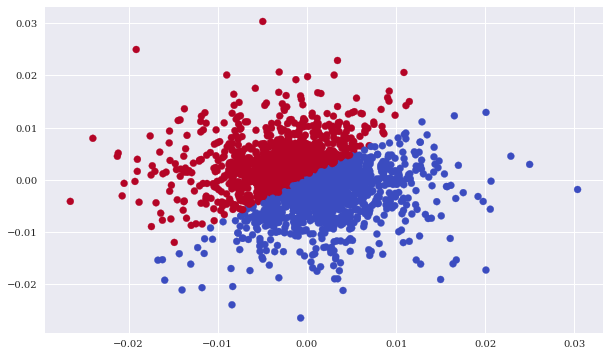

In [44]:
plt.figure(figsize=(10, 6))
# X座標はdata[cols].iloc[:, 0] でlag_1、Y座標はdata[cols].iloc[:, 1] で lag_2
# クラスタリングの結果に基づいて、色分け
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');
# plt.savefig('../../images/ch15/strat_ml_04.png');

In [45]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [46]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.810644
strat_clus    1.194203
dtype: float64

In [47]:
(data['direction'] == data['pos_clus']).value_counts()

True     1070
False    1065
dtype: int64

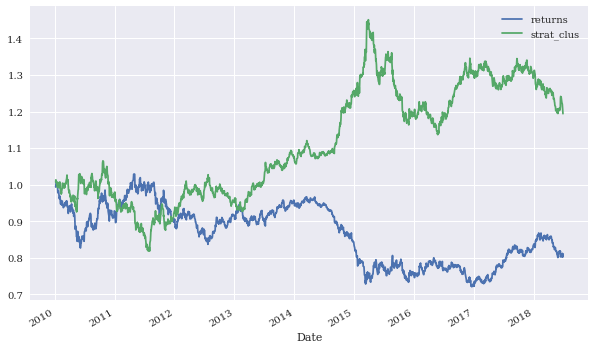

In [48]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

## Frequency Approach

In [49]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [50]:
data[cols].head()

,lag_1,lag_2
Date,,
2010-01-07,0.003058,-0.002988
2010-01-08,-0.006544,0.003058
2010-01-11,0.006544,-0.006544
2010-01-12,0.006984,0.006544
2010-01-13,-0.001310,0.006984


In [51]:
create_bins(data)

In [52]:
# lag_x 列が正の場合は1、負の場合は0になる
data[cols_bin + ['direction']].head()  

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [53]:
cols_bin + ['direction']

['lag_1_bin', 'lag_2_bin', 'direction']

In [54]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [55]:
# DataFrameオブジェクトに周波数列を追加したものをresに設定
res = grouped['direction'].size().unstack(fill_value=0)  

In [56]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [57]:
res.style.apply(highlight_max, axis=1)  

In [58]:
# lag_1_bin、lag_2_binの和が2の場合は -1方向。そうでない場合は1方向
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [59]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
dtype: int64

In [60]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [61]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.810644
strat_freq    0.989513
dtype: float64

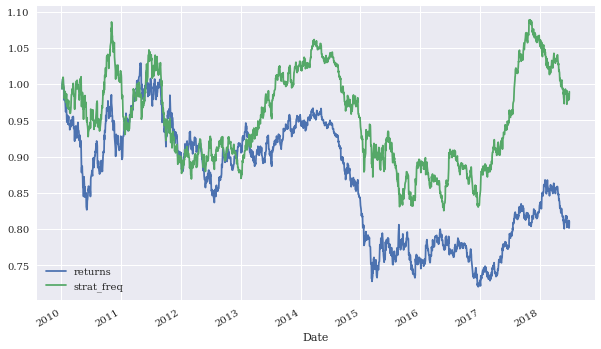

In [62]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_06.png');

## Classification Algorithms

In [63]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [64]:
C = 1

In [65]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [66]:
def fit_models(data):  
    # data[cols_bin]を説明変数、data['direction']を目的変数として重みを学習
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [67]:
fit_models(data)

In [68]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [69]:
# 学習結果を用いて direction を予測
# 各モデルに対する結果は以下に格納される
# data['pos_log_reg']
# data['pos_gauss_nb']
# data['pos_svm']
derive_positions(data)

In [70]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [71]:
evaluate_strats(data)

In [72]:
sel.insert(1, 'strat_freq')

In [73]:
data[sel].sum().apply(np.exp)  

returns           0.810644
strat_freq        0.989513
strat_log_reg     1.243322
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

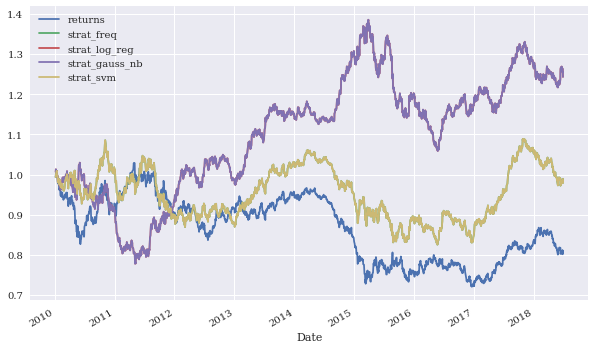

In [74]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

In [75]:
data = pd.DataFrame(raw[symbol])

In [76]:
data['returns'] = np.log(data / data.shift(1))

In [77]:
data['direction'] = np.sign(data['returns'])

In [78]:
lags = 5  
create_lags(data)
data.dropna(inplace=True)

In [79]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [80]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [81]:
data.dropna(inplace=True)

In [82]:
fit_models(data)

In [83]:
derive_positions(data)

In [84]:
evaluate_strats(data)

In [85]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     0.971623
strat_gauss_nb    0.986420
strat_svm         2.649423
dtype: float64

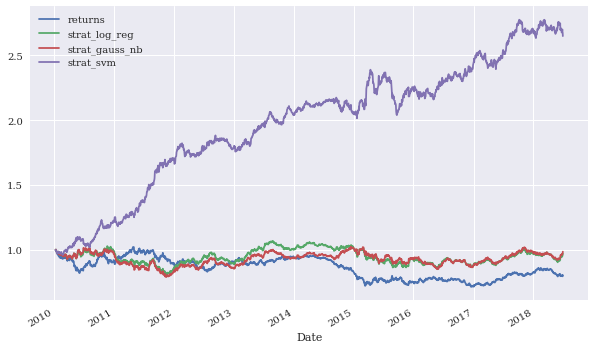

In [86]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_08.png');

In [87]:
mu = data['returns'].mean()  
v = data['returns'].std()  

In [88]:
bins = [mu - v, mu, mu + v]  
bins  

[-0.006033537040418665, -0.00010174015279231306, 0.005830056734834039]

In [89]:
create_bins(data, bins)

In [90]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [91]:
fit_models(data)

In [92]:
derive_positions(data)

In [93]:
evaluate_strats(data)

In [94]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     1.431120
strat_gauss_nb    1.815304
strat_svm         7.165290
dtype: float64

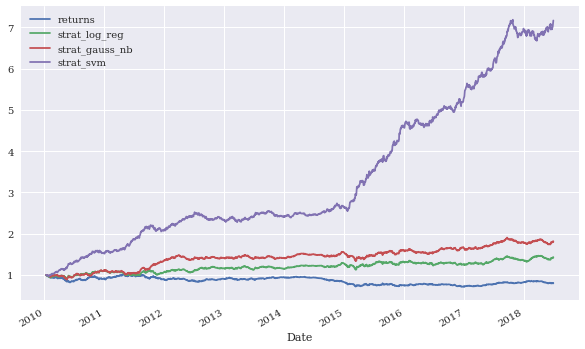

In [95]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_09.png')

### Sequential Train-Test Split

In [96]:
split = int(len(data) * 0.5)

In [97]:
train = data.iloc[:split].copy()  

In [98]:
fit_models(train)  

In [99]:
test = data.iloc[split:].copy()  

In [100]:
derive_positions(test)  

In [101]:
evaluate_strats(test)  

In [102]:
test[sel].sum().apply(np.exp)

returns           0.850291
strat_log_reg     0.952898
strat_gauss_nb    0.941172
strat_svm         1.020519
dtype: float64

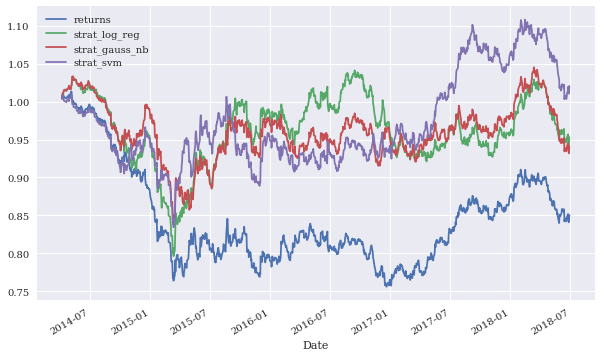

In [103]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_10.png');

### Randomized Train-Test Split

In [104]:
from sklearn.model_selection import train_test_split

In [105]:
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)

In [106]:
train = train.copy().sort_index()  

In [107]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-20,1,0,1,2,1


In [108]:
test = test.copy().sort_index()  

In [109]:
fit_models(train)

In [110]:
derive_positions(test)

In [111]:
evaluate_strats(test)

In [112]:
test[sel].sum().apply(np.exp)

returns           0.878078
strat_log_reg     0.807238
strat_gauss_nb    0.765009
strat_svm         0.730141
dtype: float64

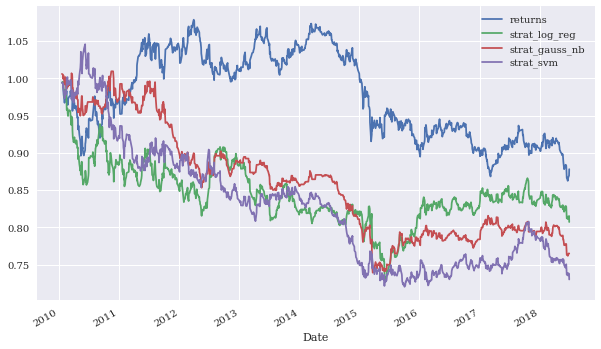

In [113]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_11.png');

## Deep Neural Network

### DNN with scikit-learn

In [114]:
from sklearn.neural_network import MLPClassifier

In [115]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [116]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 35.3 s, sys: 17.9 s, total: 53.2 s
Wall time: 19.3 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [117]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [118]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [119]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.805002
strat_dnn_sk    33.038059
dtype: float64

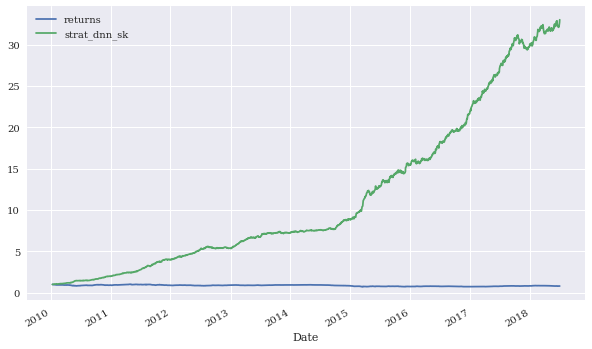

In [120]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

In [121]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [122]:
train = train.copy().sort_index()

In [123]:
test = test.copy().sort_index()

In [124]:
# hidden layer の数と hidden units の数を増やした
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [125]:
# ランダム化した訓練データを使用
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 4min 44s, sys: 1min 31s, total: 6min 16s
Wall time: 2min 3s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [126]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [127]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [128]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.113844
dtype: float64

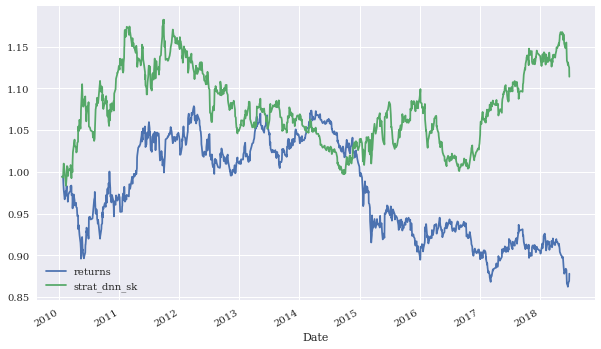

In [129]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

### DNN with Keras & TensorFlow Backend

In [130]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [ ]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [ ]:
model = create_model()

In [ ]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

In [ ]:
model.evaluate(data_[cols], data['direction_'])

In [ ]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

In [ ]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  

In [132]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [133]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.805002
strat_dnn_ke    4.840414
dtype: float64

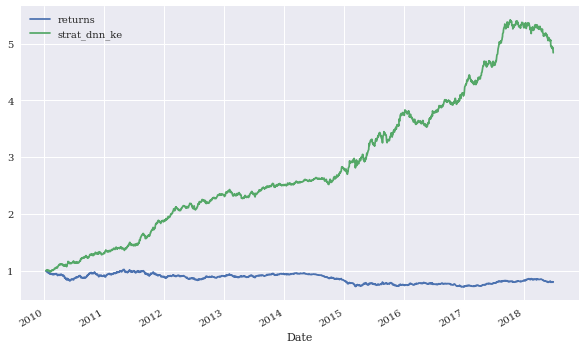

In [134]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [135]:
mu, std = train.mean(), train.std()

In [136]:
train_ = (train - mu) / mu.std()

In [137]:
model = create_model()

In [138]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [139]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

CPU times: user 2.64 s, sys: 388 ms, total: 3.03 s
Wall time: 1.93 s


In [140]:
test_ = (test - mu) / std

In [141]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [142]:
model.evaluate(test_[cols], test['direction_'])

1066/1066 [==============================] - 0s 34us/step


[1.7082206719811817, 0.501876175403595]

In [143]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [144]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [145]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [146]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.125420
strat_dnn_ke    1.040145
dtype: float64

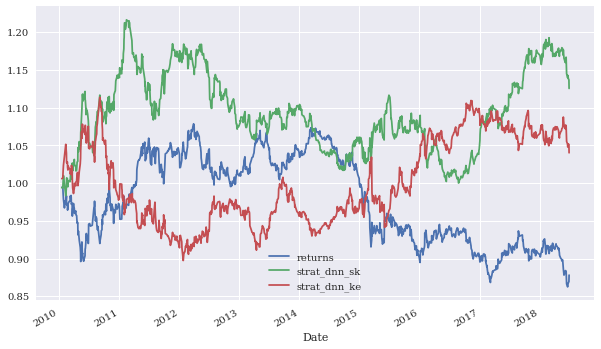

In [147]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>